In [55]:
import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import my_env, agents, utils, rollout, plot_utils, mcts
from tqdm import trange
from importlib import reload
from collections import defaultdict
from plotly import graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from time import time_ns
from random import choice
import itertools

import plotly.io as pio
pio.renderers.default='iframe'

# Пререквизиты
Сделаем среду симметричной, чтоб можно было играть самим с собой и обновлять одну и ту же политику - получать в два раза больше опыта. Для этого нужно:

1. чтоб среда выдавала не значения "пустая клетка, нолик, крестик", а "пустая клетка, мой символ, символ оппонента"
2. чтоб в игре могли начинать как "нолики", так и "крестики"
3. чтоб правильно выдавалась награда как "ноликам", так и "крестикам" (для победы и поражения)

# Часть 1

В качестве табличного метода воспользуемся стандартным Q-обучением:

$$Q(s, a) = (1 - \alpha) Q(s, a) + \alpha \frac{\pi(a|s)}{b(a|s)}[r + \gamma \max_{a'}Q(s', a')]$$

где $b(a|s)$ - эпсилон жадная стратегия

In [2]:
def plot_stats(snapshots):
    episodes = sorted(snapshots.keys())
    plots_cnt = 4
    fig = make_subplots(
        rows=plots_cnt, cols=1,
        subplot_titles=(
            "Абсолютное обновление стратегии за интервал (схождение стратегии)", 
            "Количество посещенных состояний",
            "Количество недопустимых действий эпсилон жадной политики за интервал",
            "Среднее количество побед против рандома",
        )
    )

    fig.add_trace(go.Scatter(x=episodes[1:], y=[snapshots[e]['q_diff'] for e in episodes[1:]]), 
                  row=1, col=1)

    fig.add_trace(go.Scatter(x=episodes, y=[snapshots[e]['counts'] for e in episodes]),
                  row=2, col=1)

    fig.add_trace(go.Scatter(x=episodes[1:], y=[snapshots[e]['wrong_actions'] for e in episodes[1:]]),
                  row=3, col=1)
    
    fig.add_trace(go.Scatter(x=episodes, y=[snapshots[e]['wins_ratio'] for e in episodes]),
                  row=4, col=1)

    fig.update_layout(height=1000,
                      title_text="Статистика тренировки Q-learning", showlegend=False)

    for r in range(plots_cnt):
        fig.update_xaxes(title_text="episodes", row=r)

    fig.update_yaxes(title_text="abs q diff'", row=1)
    fig.update_yaxes(title_text="number of visited states", row=2)
    fig.update_yaxes(title_text="number of wrong actions", row=3)
    fig.update_yaxes(title_text="wins ratio", row=4)
    fig.show()

In [3]:
def q_learning(env, agent, epsilon, episodes_number, gamma, alpha, snapshots_number, snapshot_games):
    snapshot_each = episodes_number // snapshots_number if snapshots_number else int(1e12)
    snapshots = {}
    stats = utils.Stats()
    counts = defaultdict(int)
    for i in trange(episodes_number):
        (s, possible_actions, turn) = env.reset()
        utils.q_learning_train_one_episode(env, agent, epsilon, gamma, alpha, counts, stats)

        if i % snapshot_each == 0 and snapshots_number:
            wins = 0
            opponent = agents.RandomAgent()
            for _ in range(snapshot_games):
                winner = utils.play_one_episode(env, agent, opponent)
                wins += int(winner == agent)
            snapshots[i] = {
                'counts': len(counts),
                'q_diff': stats.q_diff,
                'wrong_actions': stats.wrong_actions,
                'wins_ratio': wins / snapshot_games,
            }
            stats = utils.Stats()
    return snapshots, counts

In [4]:
reload(my_env), reload(agents), reload(utils)
N_ROWS, N_COLS = 3, 3
env = my_env.TicTacToe(N_ROWS, N_COLS)
agent = agents.QStrategy(0, N_ROWS, N_COLS)
snapshots, counts = q_learning(env, agent, epsilon=0.1, episodes_number=int(1e6), gamma=0.95, alpha=0.1, snapshots_number=100, snapshot_games=100)
plot_stats(snapshots)

100%|██████████████████| 1000000/1000000 [10:07<00:00, 1645.15it/s]


In [5]:
agent.dump("q_agent.data")

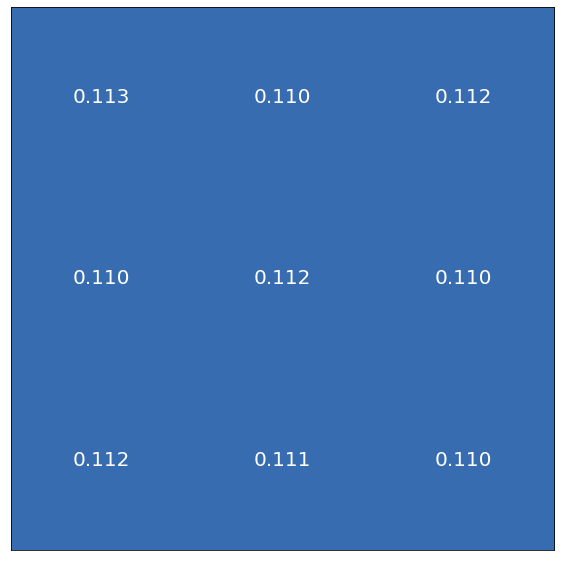

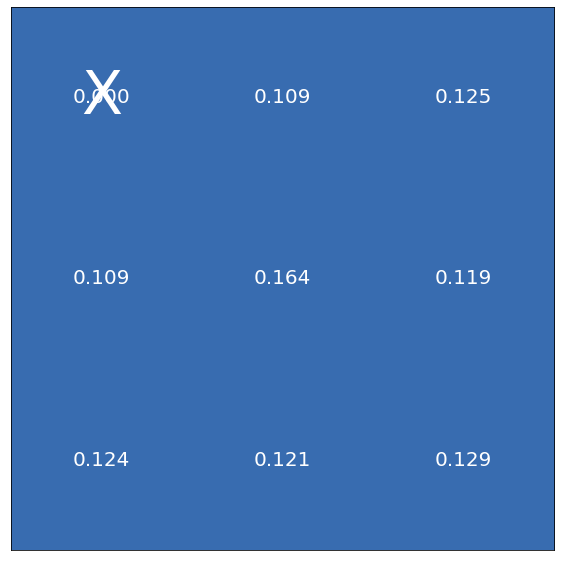

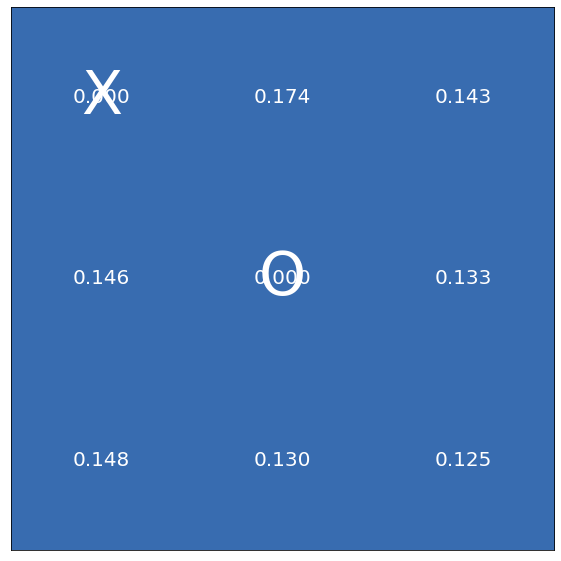

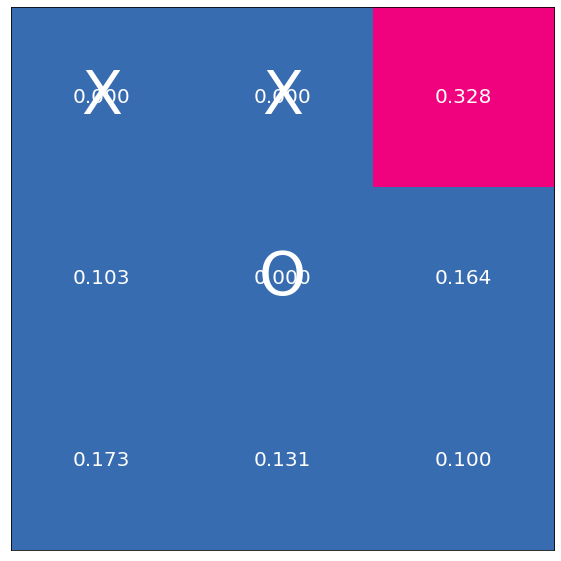

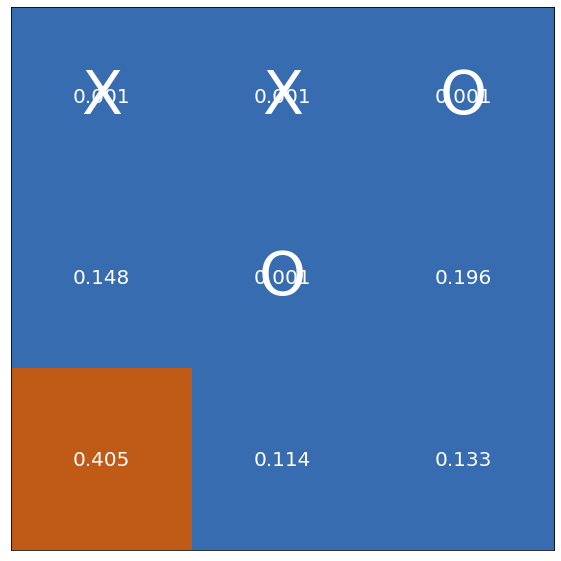

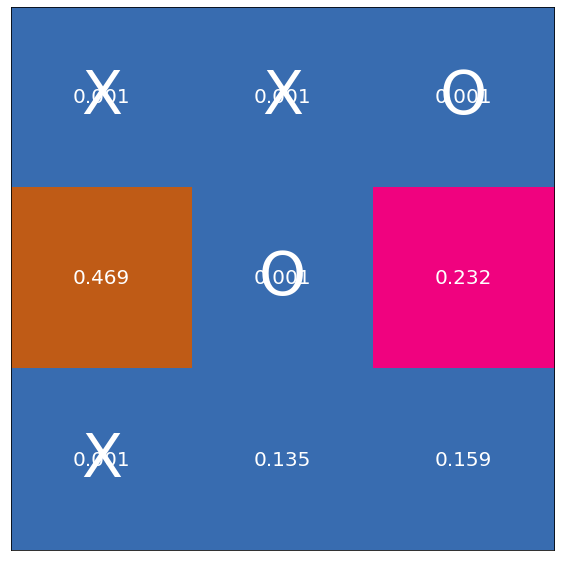

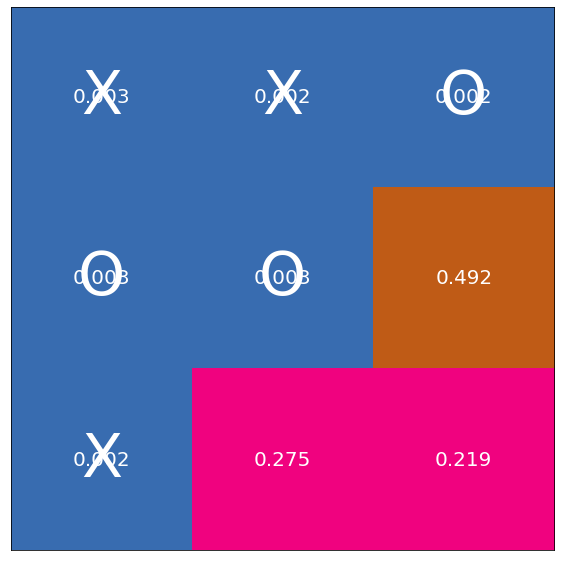

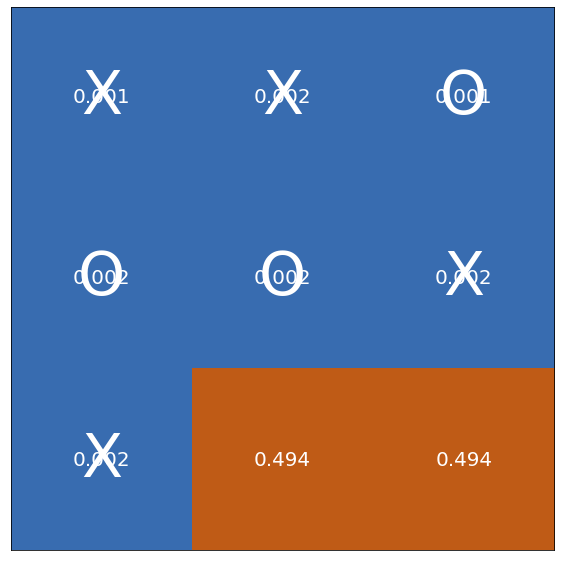

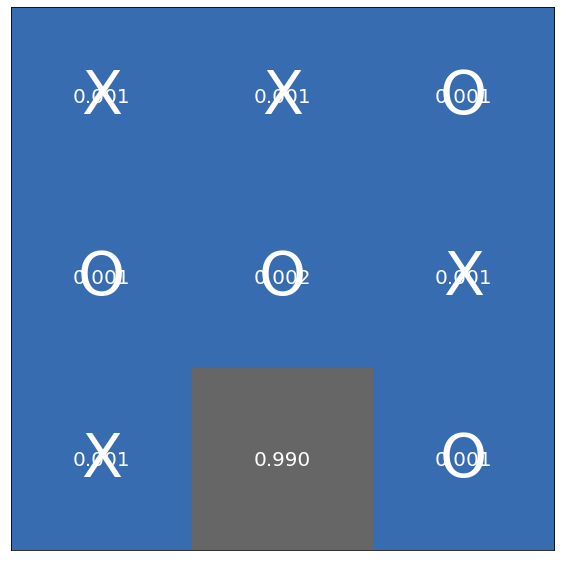

In [6]:
from plot_utils import plot_test_game
plot_test_game(env, agent, agent, random_crosses=False, random_naughts=False, verbose=False, fontx=60)

## Попробуем обучить игре большей размерности

In [7]:
reload(my_env), reload(agents)
N_ROWS, N_COLS, N_WINS = 4, 4, 4
env = my_env.TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_4 = agents.QStrategy(0, N_ROWS, N_COLS)
snapshots_4, counts_4 = q_learning(env, agent_4, epsilon=0.1, episodes_number=int(1e6), gamma=0.95, alpha=0.1, snapshots_number=100, snapshot_games=100)
plot_stats(snapshots_4)

100%|██████████████████| 1000000/1000000 [15:28<00:00, 1076.97it/s]


Как видно, процесс обучения пошел (падает количество недопустимых действий, а также падает изменение Q-функции за интервал), но очень уж долго.

# Часть 2. DQN

In [8]:
def dqn_plot_snapshots(snapshots_dqn):
    snapshots = snapshots_dqn
    episodes = sorted(snapshots.keys())
    plots_cnt = 3
    fig = make_subplots(
        rows=plots_cnt, cols=1,
        subplot_titles=(
            "Абсолютное обновление стратегии за интервал (схождение стратегии)", 
            "Количество недопустимых действий эпсилон жадной политики за интервал",
            "Среднее количество побед против рандома",
        )
    )

    fig.add_trace(go.Scatter(x=episodes[1:], y=[snapshots[e]['q_diff'] for e in episodes[1:]]), 
                  row=1, col=1)

    fig.add_trace(go.Scatter(x=episodes[1:], y=[snapshots[e]['wrong_actions'] for e in episodes[1:]]),
                  row=2, col=1)

    fig.add_trace(go.Scatter(x=episodes, y=[snapshots[e]['wins_ratio'] for e in episodes]),
                  row=3, col=1)

    fig.update_layout(height=1000,
                      title_text="Статистика тренировки Q-learning", showlegend=False)

    for r in range(plots_cnt):
        fig.update_xaxes(title_text="episodes", row=r)

    fig.update_yaxes(title_text="abs q diff'", row=1)
    fig.update_yaxes(title_text="number of wrong actions", row=2)
    fig.update_yaxes(title_text="wins ratio", row=3)
    fig.show()
    
   
def plot_train_stats(train_stats):
    x, y = train_stats.get_stats()
    plots_cnt = 2
    fig = make_subplots(
        rows=plots_cnt, cols=1,
        subplot_titles=(
            "Статистика по обучающим примерам (действия приведшие к победам, поражениям, завершениям эпизодов и тд)", 
            "Статистика по наградам (выдается средой) и таргетам (gamma*max(Q[s',a]) + reward)",
        )
    )

    for k in ('wins', 'looses', 'draws', 'wrong', 'is_done'):
        fig.add_trace(go.Scatter(x=x, y=y[k], name=k), 
                      row=1, col=1)
    for k in y.keys():
        if 'reward' in k or 'target' in k:
            fig.add_trace(go.Scatter(x=x, y=y[k], name=k), 
                          row=2, col=1)
    fig.update_layout(height=1000,
                      title_text="Статистика тренировки Q-learning")

    for r in range(plots_cnt):
        fig.update_xaxes(title_text="epoch", row=r)
    fig.update_yaxes(title_text="Stats by game in epoch", row=1)
    fig.update_yaxes(title_text="Stats of reward and target", row=2)
    fig.show()

### DQN-agent

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
reload(my_env), reload(agents), reload(utils)
N_ROWS, N_COLS, N_WINS = 3, 3, 3
env = my_env.TicTacToe(N_ROWS, N_COLS)
agent_dqn = agents.DQN(env.n_cols * env.n_rows, device, lr=0.001)
snapshots_dqn, train_stats = utils.dqn_train(
    epochs=1000, episodes_per_epoch=200, buffer_size=5000, env=env, agent=agent_dqn, epsilon=0.1, 
    gamma=0.95, batch_size=128, trains_per_epoch=10, snapshots_number=100, snapshot_games=100,
    prioritize=True, do_plot=False, dump_model_filename='dqn.data'
)
dqn_plot_snapshots(snapshots_dqn)

100%|██████████████████████████| 1000/1000 [14:42<00:00,  1.13it/s]

Best score: 80.0% wins ratio saved to dqn.data


По графику "Статистика по наградам и таргетам" видно, что в какой-то момент таргет сильно начинает завышать среднюю награду (и тем более максимальный таргет начинает расходиться). Вероятно это происходит из-за того, что возникает петля положительной связи: $$target=\gamma max Q'(s_{next}, a) + R$$. То есть, если сеть выучит следующее значение достаточно большим, то потом это будет использоваться в качестве тагрета для следующего обновления.

Для того, чтоб с этим побороться применяются две методики:
1) $Q'$ - это все-таки не совсем текущая Q (а завфиксированная с предыдущей итерации)
2) если это финальный эпизод, то в качестве таргета берется только $R_T$. Тем самым стратегия подтягивается в финальных состояниях к реальным значениям награды

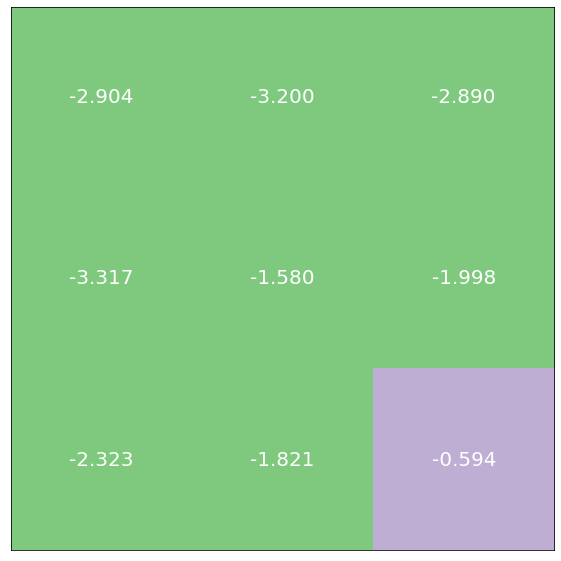

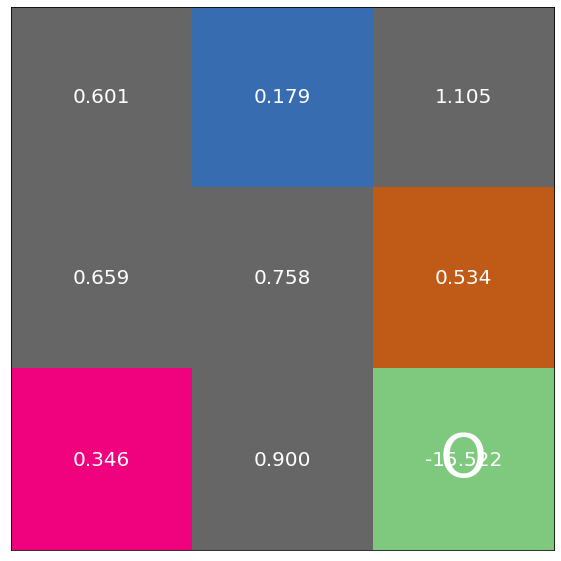

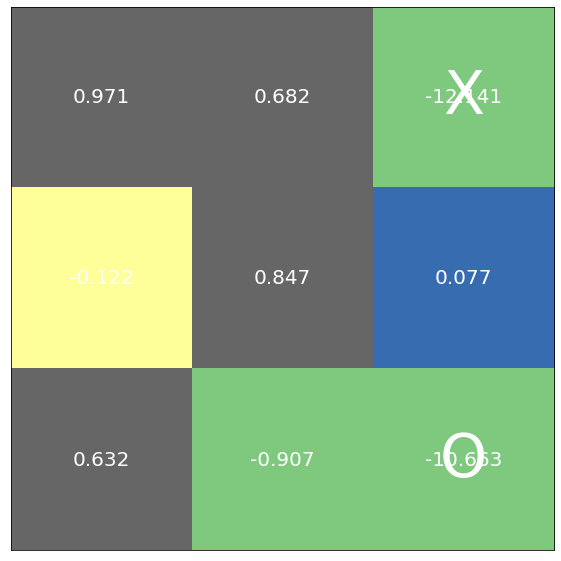

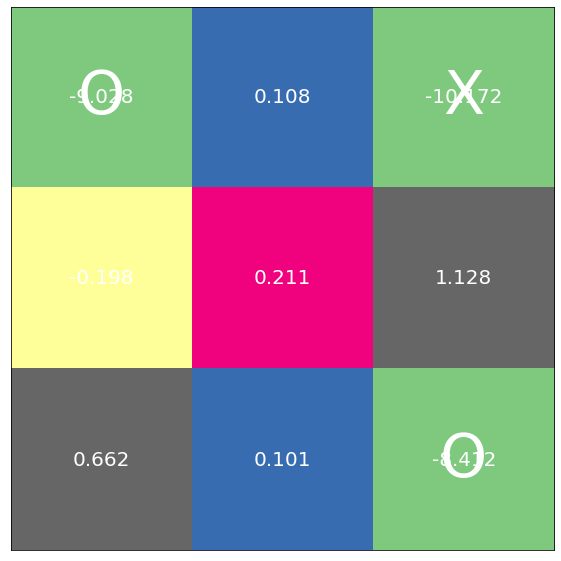

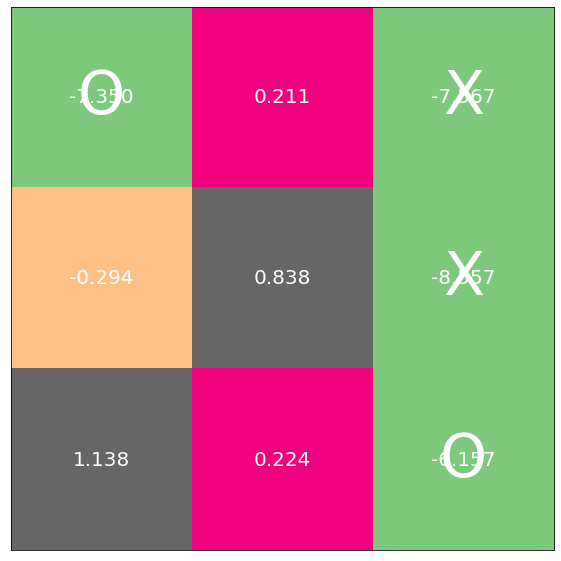

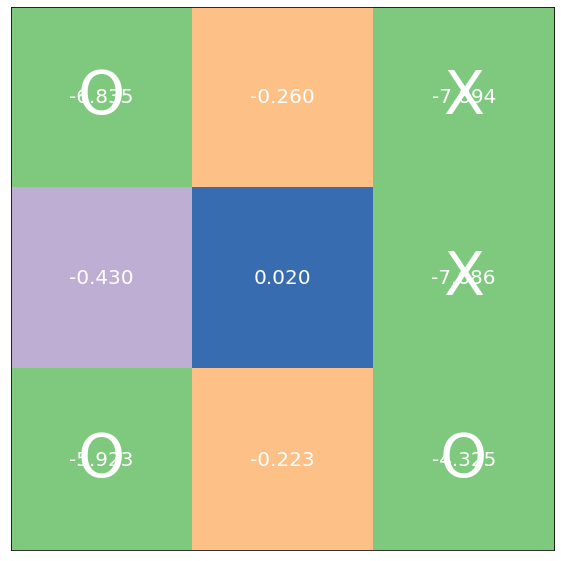

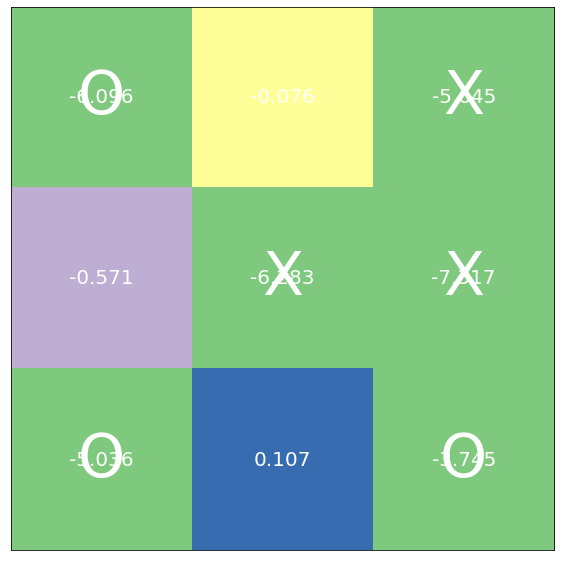

Крестики выиграли!


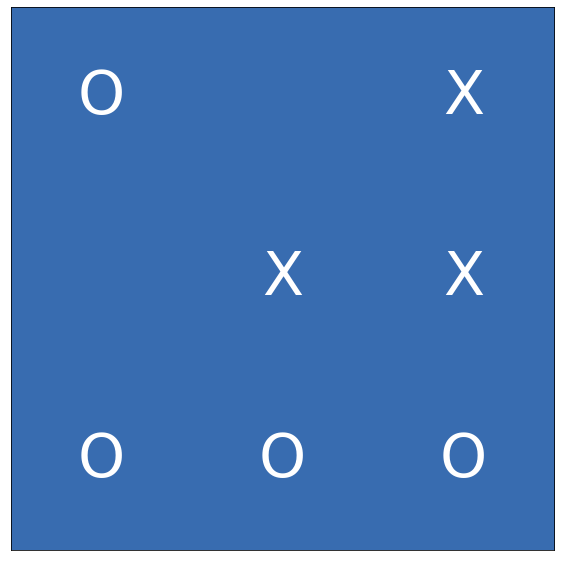

In [10]:
from plot_utils import plot_test_game
reload(agents)
agent_dqn = torch.load('dqn.data')
player = agents.DQNPlayerWrapper(env, agent_dqn)
plot_test_game(env, player, player, random_crosses=False, random_naughts=False, verbose=False, fontx=60)

### Duelling DQN

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
reload(my_env), reload(agents), reload(utils)
N_ROWS, N_COLS, N_WINS = 3, 3, 3
env = my_env.TicTacToe(N_ROWS, N_COLS)
filename = 'duelling_dqn.data'
if os.path.isfile(filename):
    agent_dqn = torch.load(filename)
else:
    agent_dqn = agents.DuelingDQN(env.n_cols * env.n_rows, device, lr=0.001)
snapshots_dqn, train_stats = utils.dqn_train(
    epochs=3000, episodes_per_epoch=200, buffer_size=5000, env=env, agent=agent_dqn, epsilon=0.1, 
    gamma=0.95, batch_size=128, trains_per_epoch=10, snapshots_number=100, snapshot_games=100,
    prioritize=True, do_plot=False, dump_model_filename=filename
)
dqn_plot_snapshots(snapshots_dqn)

100%|██████████████████████████| 3000/3000 [42:35<00:00,  1.17it/s]

Best score: 92.0% wins ratio saved to duelling_dqn.data


In [21]:
plot_train_stats(train_stats)

Видно, что при обучении в итоге таргет сходится к средней награде. И это хорошо, однако требуется достаточно много эпизодов


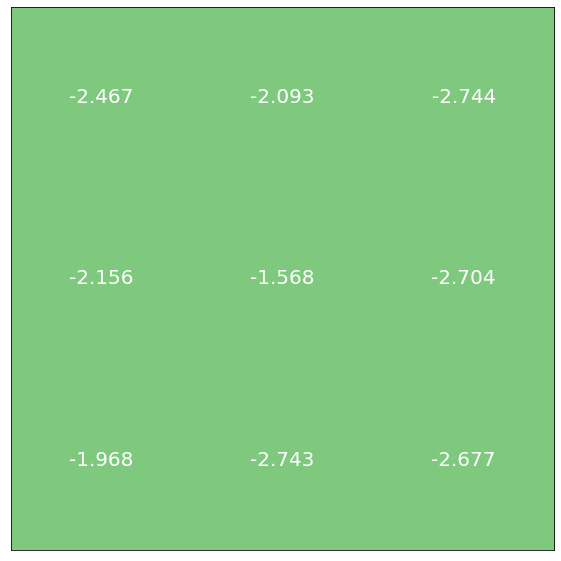

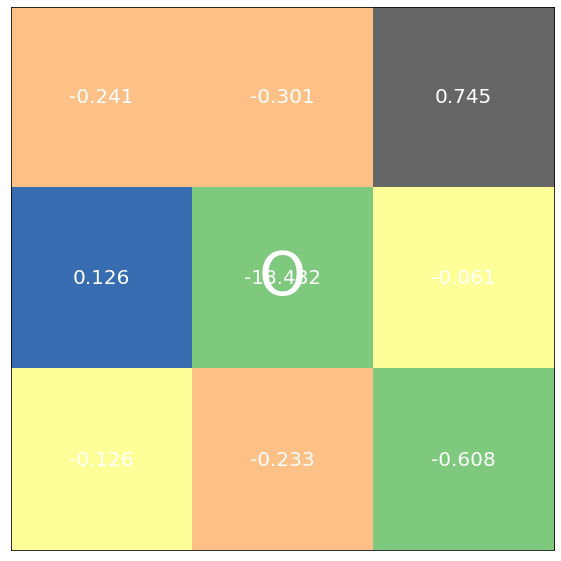

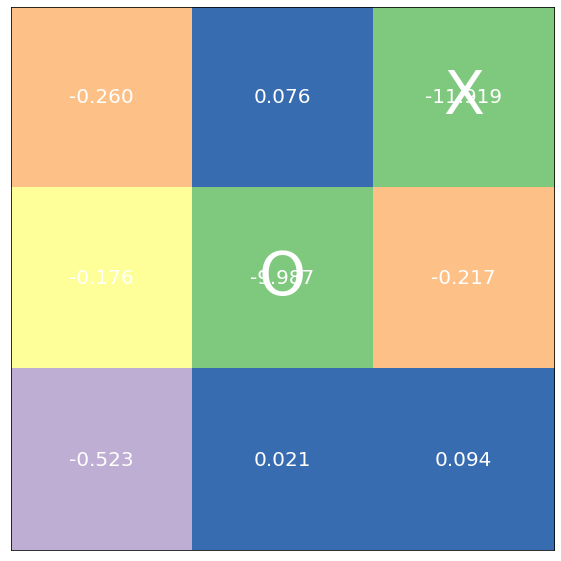

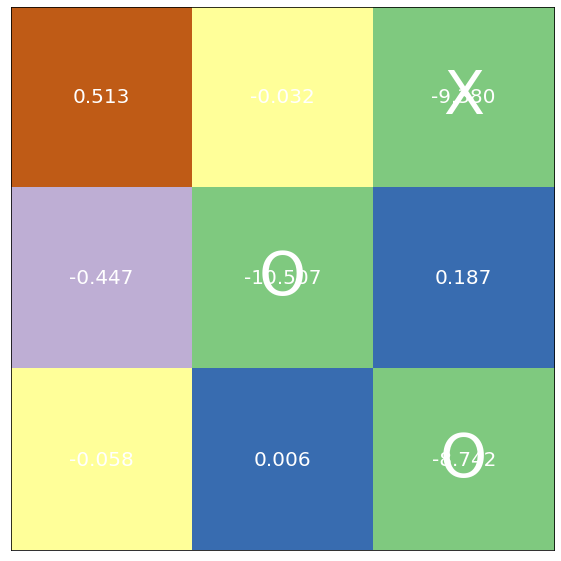

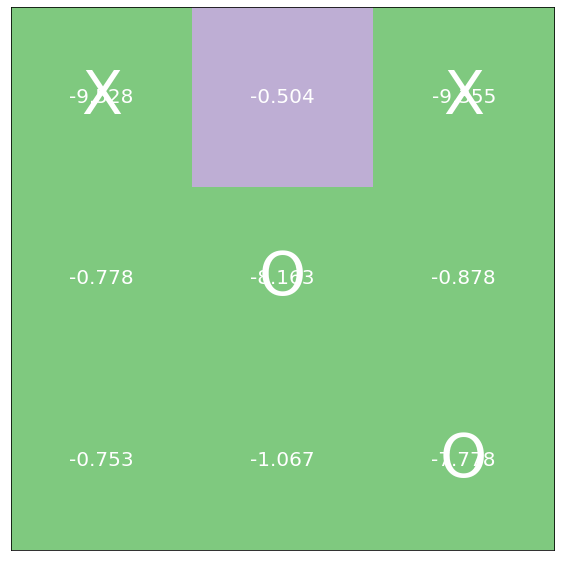

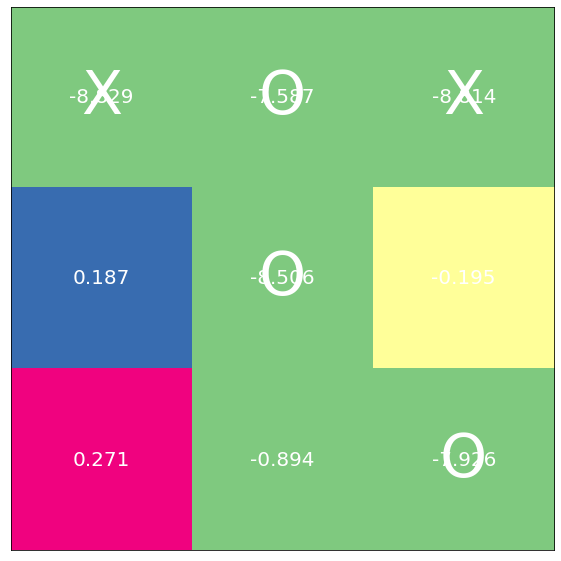

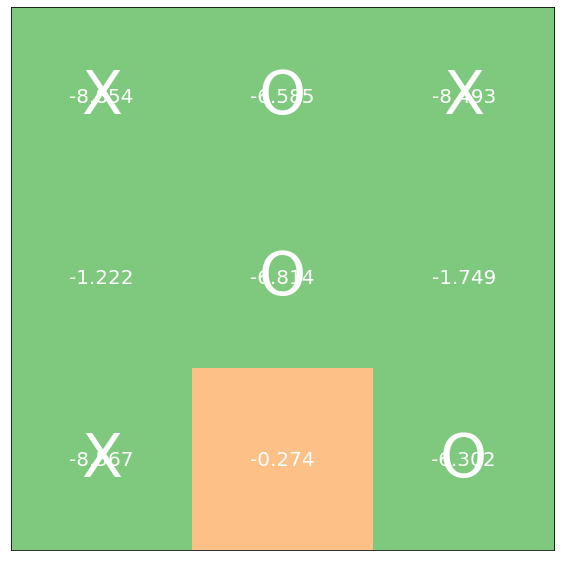

Крестики выиграли!


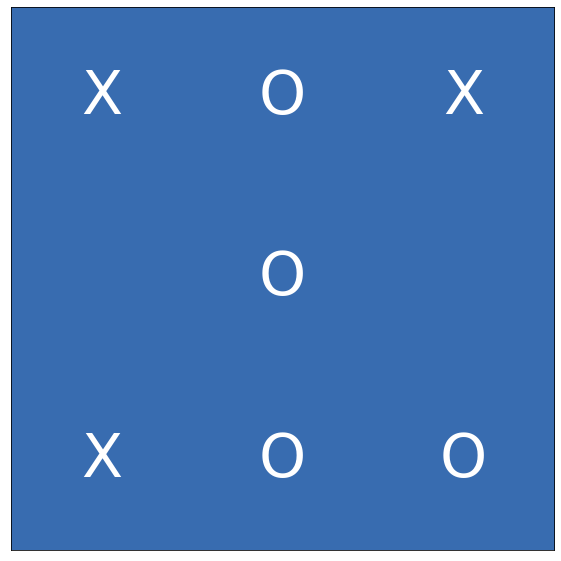

In [26]:
reload(plot_utils), reload(agents)
agent_dqn = torch.load(filename)
player = agents.DQNPlayerWrapper(env, agent_dqn)
plot_utils.plot_test_game(env, player, player, random_crosses=False, random_naughts=False, verbose=False, fontx=60)

# Часть 3

## Rollouts

Возьмем базовую версию агента сначала рандомного, затем полученного из первого пункта и сравним, насколько лучше играет агент с роллаутами

In [27]:
def plot_rollouts(rollouts_per_state, results, times):
    plots_cnt = 2
    fig = make_subplots(
        rows=plots_cnt, cols=1,
        subplot_titles=(
            "Количество побед по 100 партиям агента с роллаутами против агента без", 
            "Время игры 100 партий",
        )
    )

    fig.add_trace(go.Scatter(x=rollouts_per_state, y=results, name='win rate'), 
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=rollouts_per_state, y=times, name='seconds'), 
                  row=2, col=1)

    fig.update_layout(
        height=1000, showlegend=False,
        title_text="Статистика агента с роллаутами против агента без",
    )

    for r in range(plots_cnt):
        fig.update_xaxes(title_text="rollouts cnt", row=r)
    fig.update_yaxes(title_text="win rate", row=1)
    fig.update_yaxes(title_text="seconds", row=2)
    fig.show()

In [28]:
def play_rollouts(env, agent_factory, rollouts_per_state):
    results, times = [], []
    for rollout_cnt in rollouts_per_state:
        start = time_ns()
        wins, games = 0, 100
        rollout_player = rollout.RolloutPlayer(
            env, agent_factory(), rollouts_per_state=rollout_cnt, ucb_c=0.4, is_stochastic=False
        )
        opponent = agent_factory()
        for i in range(games):
            winner = utils.play_one_episode(env, rollout_player, opponent)
            wins += int(winner == rollout_player)
        times.append((time_ns() - start)/1e9)
        results.append(wins / games)
    return results, times


In [29]:
reload(my_env), reload(agents), reload(utils)
N_ROWS, N_COLS, N_WINS = 3, 3, 3
env = my_env.TicTacToe(N_ROWS, N_COLS, N_WINS)

rollouts_per_state = (10, 20, 30, 50, 70, 100, 200, 300, 500, 800, 1000)
results, times = play_rollouts(env, agents.RandomAgent, rollouts_per_state)
plot_rollouts(rollouts_per_state, results, times)

In [31]:
reload(my_env), reload(agents), reload(utils)
q_agent_factory = lambda: agents.QStrategy.load('q_agent.data')

N_ROWS, N_COLS, N_WINS = 3, 3, 3
env = my_env.TicTacToe(N_ROWS, N_COLS, N_WINS)
rollouts_per_state = (10, 20, 30, 50, 70, 100, 150, 200, 300, 500)
results, times = play_rollouts(env, q_agent_factory, rollouts_per_state)
plot_rollouts(rollouts_per_state, results, times)

Видимо Q-агент на сетке 3x3 уже и так весьма хорошо обучен, ему выигрыш ролауты не дают.

# Часть 3. MCTS

In [53]:
reload(my_env), reload(agents), reload(utils), reload(rollout), reload(mcts), reload(plot_utils)
N_ROWS, N_COLS, N_WINS = 3, 3, 3
env = my_env.TicTacToe(N_ROWS, N_COLS, N_WINS)

rollouts = (10, 20, 30, 50, 100)
mcts_counts = (10, 20, 30, 50, 100)
results = []
for rollouts_cnt, mcts_cnt in itertools.product(rollouts, mcts_counts):
    start = time_ns()
    wins, games = 0, 100
    env.reset()
    mcts_player = mcts.MCTSPlayer(env, agents.RandomAgent(), agents.RandomAgent(), mcts_cnt, alpha=0.0, rollouts_per_update=rollouts_cnt, ucb_c=0.2)
    opponent = agents.RandomAgent()
    for i in range(games):
        winner = utils.play_one_episode(env, mcts_player, opponent)
        wins += int(winner == mcts_player)
    print(f'Rollouts {rollouts_cnt}, mcts_cnt: {mcts_cnt}, games {games}, wins {wins}, ratio {wins/games}, took {(time_ns() - start)/1e9}s')
    results.append({'rollouts_cnt': rollouts_cnt, 'mcts_cnt': mcts_cnt, 'wins_ratio': wins / games})

Rollouts 10, mcts_cnt: 10, games 100, wins 89, ratio 0.89, took 5.930606s
Rollouts 10, mcts_cnt: 20, games 100, wins 91, ratio 0.91, took 11.027011s
Rollouts 10, mcts_cnt: 30, games 100, wins 89, ratio 0.89, took 15.689516s
Rollouts 10, mcts_cnt: 50, games 100, wins 90, ratio 0.9, took 23.761783s
Rollouts 10, mcts_cnt: 100, games 100, wins 94, ratio 0.94, took 44.486669s
Rollouts 20, mcts_cnt: 10, games 100, wins 89, ratio 0.89, took 11.785077s
Rollouts 20, mcts_cnt: 20, games 100, wins 88, ratio 0.88, took 20.609513s
Rollouts 20, mcts_cnt: 30, games 100, wins 94, ratio 0.94, took 30.045145s
Rollouts 20, mcts_cnt: 50, games 100, wins 95, ratio 0.95, took 46.599648s
Rollouts 20, mcts_cnt: 100, games 100, wins 98, ratio 0.98, took 82.008624s
Rollouts 30, mcts_cnt: 10, games 100, wins 88, ratio 0.88, took 17.20371s
Rollouts 30, mcts_cnt: 20, games 100, wins 87, ratio 0.87, took 32.527703s
Rollouts 30, mcts_cnt: 30, games 100, wins 91, ratio 0.91, took 44.863439s
Rollouts 30, mcts_cnt: 50,

In [59]:
pd.DataFrame(results).transpose()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
rollouts_cnt,10.00,10.00,10.00,10.0,10.00,20.00,20.00,20.00,20.00,20.00,...,50.00,50.00,50.00,50.00,50.00,100.00,100.00,100.00,100.00,100.00
mcts_cnt,10.00,20.00,30.00,50.0,100.00,10.00,20.00,30.00,50.00,100.00,...,10.00,20.00,30.00,50.00,100.00,10.00,20.00,30.00,50.00,100.00
wins_ratio,0.89,0.91,0.89,0.9,0.94,0.89,0.88,0.94,0.95,0.98,...,0.87,0.95,0.87,0.93,0.95,0.93,0.94,0.93,0.93,0.98


In [85]:
fig = go.Figure(
    data=go.Heatmap(
        z=[x['wins_ratio'] for x in results],
        x=[x['rollouts_cnt'] for x in results],
        y=[x['mcts_cnt'] for x in results], )
)
fig.update_layout(
    title="Результаты игры MCTS от рандомного агента против этого агента",
)
fig.update_xaxes(title_text="rollouts")
fig.update_yaxes(title_text="mcts_cnt")
fig.show()